In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytrends

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pytrends.request import TrendReq
from sklearn.pipeline import Pipeline
import itertools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
import joblib

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Car Sales.xlsx - car_data.csv')

# Display the first few rows of the DataFrame to verify
print(df.head())

         Car_id      Date Customer Name Gender  Annual Income  \
0  C_CND_000001  1/2/2022     Geraldine   Male          13500   
1  C_CND_000002  1/2/2022           Gia   Male        1480000   
2  C_CND_000003  1/2/2022        Gianna   Male        1035000   
3  C_CND_000004  1/2/2022       Giselle   Male          13500   
4  C_CND_000005  1/2/2022         Grace   Male        1465000   

                           Dealer_Name   Company       Model  \
0  Buddy Storbeck's Diesel Service Inc      Ford  Expedition   
1                     C & M Motors Inc     Dodge     Durango   
2                          Capitol KIA  Cadillac    Eldorado   
3               Chrysler of Tri-Cities    Toyota      Celica   
4                    Chrysler Plymouth     Acura          TL   

                      Engine Transmission       Color  Price ($)  Dealer_No   \
0  DoubleÂ Overhead Camshaft         Auto       Black      26000  06457-3834   
1  DoubleÂ Overhead Camshaft         Auto       Black      19000

# EDA

In [ ]:
print(df.columns)

Index(['Car_id', 'Date', 'Customer Name', 'Gender', 'Annual Income',
       'Dealer_Name', 'Company', 'Model', 'Engine', 'Transmission', 'Color',
       'Price ($)', 'Dealer_No ', 'Body Style', 'Phone', 'Dealer_Region'],
      dtype='object')


In [ ]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Car_id         23906 non-null  object
 1   Date           23906 non-null  object
 2   Customer Name  23905 non-null  object
 3   Gender         23906 non-null  object
 4   Annual Income  23906 non-null  int64 
 5   Dealer_Name    23906 non-null  object
 6   Company        23906 non-null  object
 7   Model          23906 non-null  object
 8   Engine         23906 non-null  object
 9   Transmission   23906 non-null  object
 10  Color          23906 non-null  object
 11  Price ($)      23906 non-null  int64 
 12  Dealer_No      23906 non-null  object
 13  Body Style     23906 non-null  object
 14  Phone          23906 non-null  int64 
 15  Dealer_Region  23906 non-null  object
dtypes: int64(3), object(13)
memory usage: 2.9+ MB
None


,Annual Income,Price ($),Phone
count,2.390600e+04,23906.000000,2.390600e+04
mean,8.308403e+05,28090.247846,7.497741e+06
std,7.200064e+05,14788.687608,8.674920e+05
min,1.008000e+04,1200.000000,6.000101e+06
25%,3.860000e+05,18001.000000,6.746495e+06
50%,7.350000e+05,23000.000000,7.496198e+06
75%,1.175750e+06,34000.000000,8.248146e+06
max,1.120000e+07,85800.000000,8.999579e+06


# Preprocessing

In [ ]:
# 1. Ubah kolom tanggal jadi datetime
df['Date'] = pd.to_datetime(df['Date'])

# 2. Buat kolom hari
df['Day'] = df['Date'].dt.to_period('D')

df

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region,Day
0,C_CND_000001,2022-01-02,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown,2022-01-02
1,C_CND_000002,2022-01-02,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora,2022-01-02
2,C_CND_000003,2022-01-02,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville,2022-01-02
3,C_CND_000004,2022-01-02,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco,2022-01-02
4,C_CND_000005,2022-01-02,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville,2022-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23901,C_CND_023902,2023-12-31,Martin,Male,13500,C & M Motors Inc,Plymouth,Voyager,Overhead Camshaft,Manual,Red,12000,60504-7114,Passenger,8583598,Pasco,2023-12-31
23902,C_CND_023903,2023-12-31,Jimmy,Female,900000,Ryder Truck Rental and Leasing,Chevrolet,Prizm,DoubleÂ Overhead Camshaft,Auto,Black,16000,06457-3834,Hardtop,7914229,Middletown,2023-12-31
23903,C_CND_023904,2023-12-31,Emma,Male,705000,Chrysler of Tri-Cities,BMW,328i,Overhead Camshaft,Manual,Red,21000,99301-3882,Sedan,7659127,Scottsdale,2023-12-31
23904,C_CND_023905,2023-12-31,Victoire,Male,13500,Chrysler Plymouth,Chevrolet,Metro,DoubleÂ Overhead Camshaft,Auto,Black,31000,53546-9427,Passenger,6030764,Austin,2023-12-31


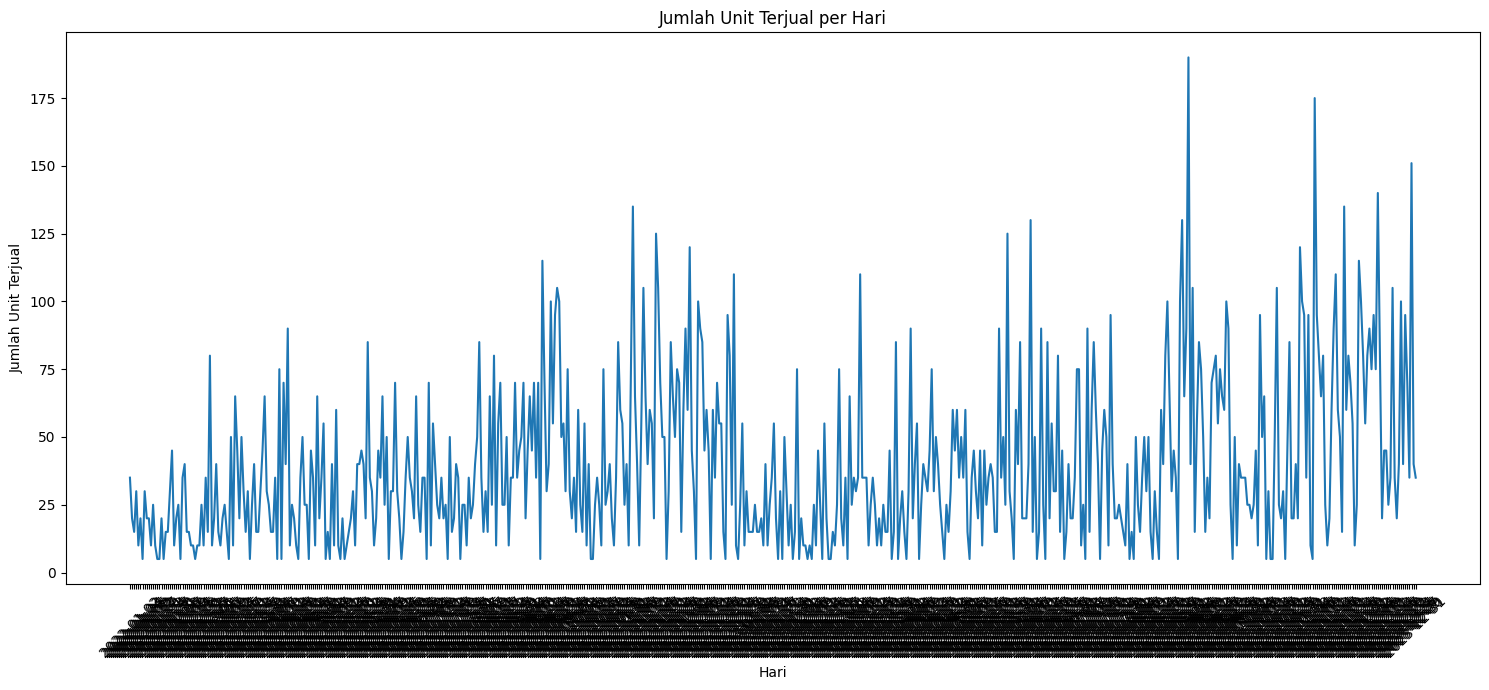

In [ ]:
daily_sales = df.groupby('Day')['Car_id'].count().reset_index()
daily_sales['Day'] = daily_sales['Day'].astype(str)

# Visualisasi
plt.figure(figsize=(15, 7))
sns.lineplot(data=daily_sales, x='Day', y='Car_id') # Use 'Car_id' for plotting
plt.title('Jumlah Unit Terjual per Hari')
plt.xlabel('Hari')
plt.ylabel('Jumlah Unit Terjual')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

grafik harian terlalu banyak noisenya, sehingga model akan merasa kesulitan mempelajari data se chaotic ini

<Axes: title={'center': 'Total Units Sold per Week'}, xlabel='Date'>

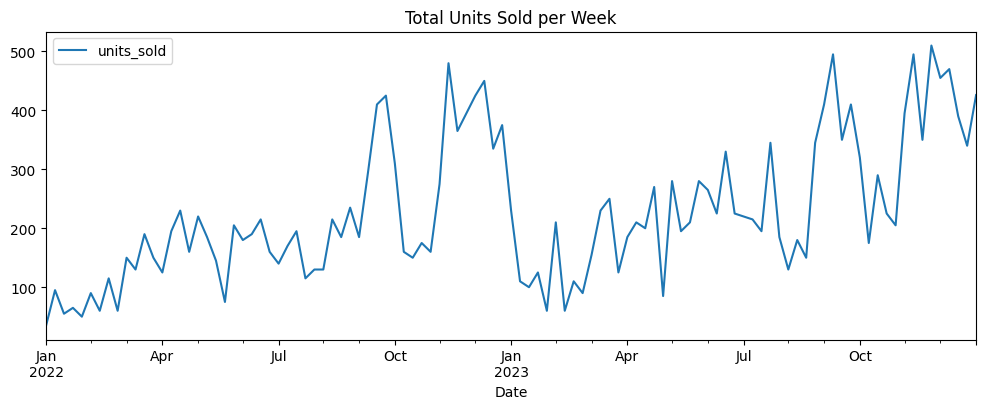

In [ ]:
# Pastikan kolom Date dalam datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Agregasi penjualan semua company per minggu
weekly_all_df = df.groupby(pd.Grouper(key='Date', freq='W'))['Car_id'].count().reset_index()
weekly_all_df = weekly_all_df.rename(columns={'Car_id': 'units_sold'})
weekly_all_df = weekly_all_df.set_index('Date').asfreq('W')
weekly_all_df['units_sold'] = weekly_all_df['units_sold'].fillna(0)

weekly_all_df.head()
weekly_all_df.plot(title='Total Units Sold per Week', figsize=(12, 4))


# Bikin model

In [ ]:
def smape(y_true, y_pred, eps=1e-9):
    # konversi ke ndarray agar operasi vectorized
    y_t   = np.abs(np.asarray(y_true))
    y_hat = np.abs(np.asarray(y_pred))

    denom = (y_t + y_hat) / 2.0
    diff  = np.abs(y_hat - y_t)

    smape_vals = np.where(denom > eps, diff / denom, 0.0)
    return 100.0 * np.mean(smape_vals)


In [ ]:
# Data series
y = weekly_all_df['units_sold']
n_forecast = 10
train = y[:-n_forecast]
test  = y[-n_forecast:]

# Parameter grid
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 52

results = []
best_model   = None
best_smape   = float('inf')          # lebih kecil = lebih baik

for order in itertools.product(p, [1], q):
    for seasonal_order in itertools.product(P, [1], Q):
        seasonal_order_full = seasonal_order + (s,)
        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=seasonal_order_full,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            fitted   = model.fit(disp=False)
            forecast = fitted.forecast(steps=n_forecast)
            forecast.index = test.index

            mae   = mean_absolute_error(test, forecast)
            sMAPE = smape(test, forecast)

            results.append((order, seasonal_order_full, sMAPE, mae))

            if sMAPE < best_smape:                   # pilih yang smape TERKECIL
                best_smape = sMAPE
                best_model = (order, seasonal_order_full, fitted, forecast)

            print(f"SARIMA{order}x{seasonal_order_full} -> "
                  f"sMAPE: {sMAPE:.3f}%, MAE: {mae:.2f}")

        except Exception as e:
            print(f"Failed SARIMA{order}x{seasonal_order_full} -> {e}")

print(f"\nBest model by sMAPE: SARIMA{best_model[0]}x{best_model[1]} "
      f"with sMAPE = {best_smape:.3f}%")

SARIMA(0, 1, 0)x(0, 1, 0, 52) -> sMAPE: 13.465%, MAE: 52.60


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 0)x(0, 1, 1, 52) -> sMAPE: 13.465%, MAE: 52.60


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 0)x(1, 1, 0, 52) -> sMAPE: 13.465%, MAE: 52.60


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 0)x(1, 1, 1, 52) -> sMAPE: 13.465%, MAE: 52.60
SARIMA(0, 1, 1)x(0, 1, 0, 52) -> sMAPE: 13.611%, MAE: 53.31


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 1)x(0, 1, 1, 52) -> sMAPE: 14.282%, MAE: 56.29


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 1)x(1, 1, 0, 52) -> sMAPE: 14.282%, MAE: 56.29


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 1)x(1, 1, 1, 52) -> sMAPE: 14.282%, MAE: 56.29
SARIMA(0, 1, 2)x(0, 1, 0, 52) -> sMAPE: 13.610%, MAE: 53.31


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 2)x(0, 1, 1, 52) -> sMAPE: 13.520%, MAE: 52.94


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 2)x(1, 1, 0, 52) -> sMAPE: 13.614%, MAE: 53.41


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 2)x(1, 1, 1, 52) -> sMAPE: 13.520%, MAE: 52.94
SARIMA(1, 1, 0)x(0, 1, 0, 52) -> sMAPE: 16.292%, MAE: 64.31


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 0)x(0, 1, 1, 52) -> sMAPE: 16.292%, MAE: 64.31


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 0)x(1, 1, 0, 52) -> sMAPE: 16.292%, MAE: 64.31


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 0)x(1, 1, 1, 52) -> sMAPE: 16.292%, MAE: 64.31
SARIMA(1, 1, 1)x(0, 1, 0, 52) -> sMAPE: 13.611%, MAE: 53.32


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 1)x(0, 1, 1, 52) -> sMAPE: 14.507%, MAE: 57.21


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 1)x(1, 1, 0, 52) -> sMAPE: 14.507%, MAE: 57.21


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 1)x(1, 1, 1, 52) -> sMAPE: 14.507%, MAE: 57.21
SARIMA(1, 1, 2)x(0, 1, 0, 52) -> sMAPE: 13.546%, MAE: 53.14


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 2)x(0, 1, 1, 52) -> sMAPE: 13.509%, MAE: 52.83


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 2)x(1, 1, 0, 52) -> sMAPE: 13.538%, MAE: 52.98


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 2)x(1, 1, 1, 52) -> sMAPE: 13.509%, MAE: 52.83
SARIMA(2, 1, 0)x(0, 1, 0, 52) -> sMAPE: 15.315%, MAE: 60.92


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 0)x(0, 1, 1, 52) -> sMAPE: 15.315%, MAE: 60.92


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 0)x(1, 1, 0, 52) -> sMAPE: 15.315%, MAE: 60.92


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 0)x(1, 1, 1, 52) -> sMAPE: 15.315%, MAE: 60.92
SARIMA(2, 1, 1)x(0, 1, 0, 52) -> sMAPE: 13.365%, MAE: 52.78


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 1)x(0, 1, 1, 52) -> sMAPE: 15.668%, MAE: 61.73


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 1)x(1, 1, 0, 52) -> sMAPE: 15.668%, MAE: 61.73


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 1)x(1, 1, 1, 52) -> sMAPE: 15.668%, MAE: 61.73
SARIMA(2, 1, 2)x(0, 1, 0, 52) -> sMAPE: 13.317%, MAE: 52.66


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 2)x(0, 1, 1, 52) -> sMAPE: 14.574%, MAE: 56.72


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 2)x(1, 1, 0, 52) -> sMAPE: 14.573%, MAE: 56.71


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 2)x(1, 1, 1, 52) -> sMAPE: 14.574%, MAE: 56.72

Best model by sMAPE: SARIMA(2, 1, 2)x(0, 1, 0, 52) with sMAPE = 13.317%


In [ ]:
# Pisah train-test
n_forecast = 10
y = weekly_all_df['units_sold']
train = y[:-n_forecast]
test = y[-n_forecast:]

# SARIMA: parameter default awal (nanti bisa tuning)
order = (2, 1, 2)
seasonal_order = (0, 1, 0, 52)

model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
fitted_model = model.fit(disp=False)

# Forecast
forecast = fitted_model.forecast(steps=n_forecast)
forecast.index = test.index

# Evaluasi
mae = mean_absolute_error(test, forecast)
sMAPE = smape(test, forecast)

print(f"MAE: {mae:.2f} | sMAPE: {sMAPE:.3f}")

MAE: 52.66 | sMAPE: 13.317


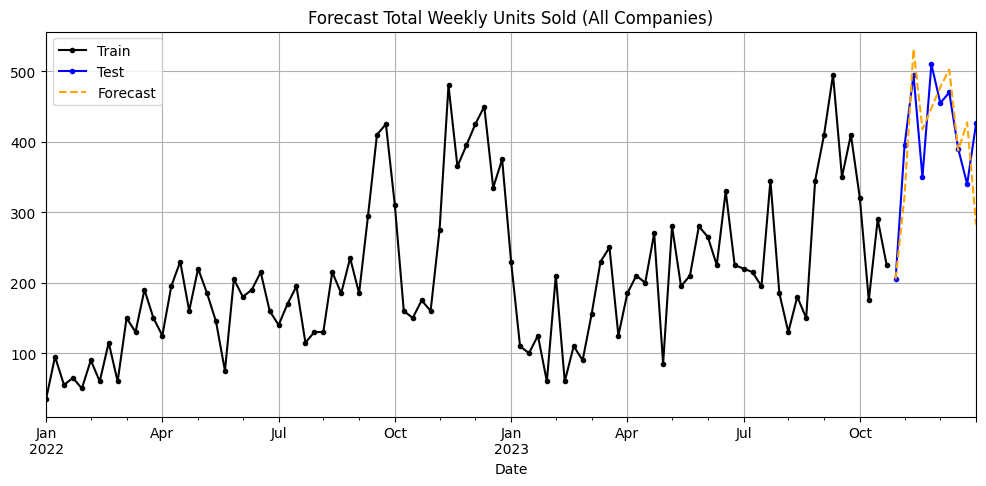

In [ ]:
plt.figure(figsize=(12, 5))
train.plot(label='Train', style='.-', color='black')
test.plot(label='Test', style='.-', color='blue')
forecast.plot(label='Forecast', style='--', color='orange')
plt.title("Forecast Total Weekly Units Sold (All Companies)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def sarima_tscv(y, order=(2,1,2), seasonal_order=(0,1,0,52),
                n_splits=5, test_size=10, min_train_size=70):
    results = []

    for i in range(n_splits):
        train_end = min_train_size + i*test_size
        test_start = train_end
        test_end = test_start + test_size

        if test_end > len(y):
            break

        y_train = y[:train_end]
        y_test = y[test_start:test_end]

        try:
            model = SARIMAX(y_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            fitted = model.fit(disp=False)
            y_pred = fitted.forecast(steps=test_size)
            y_pred.index = y_test.index

            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            results.append({'fold': i+1, 'mae': mae, 'r2': r2, 'smape': smape(y_test, y_pred),'y_train': y_train, 'y_test': y_test, 'y_pred': y_pred})

        except Exception as e:
            print(f"Fold {i+1} ERROR: {e}")
            results.append({'fold': i+1, 'mae': np.nan, 'r2': np.nan, 'smape': np.nan,'y_train': y_train, 'y_test': y_test, 'y_pred': None})

    return pd.DataFrame(results)

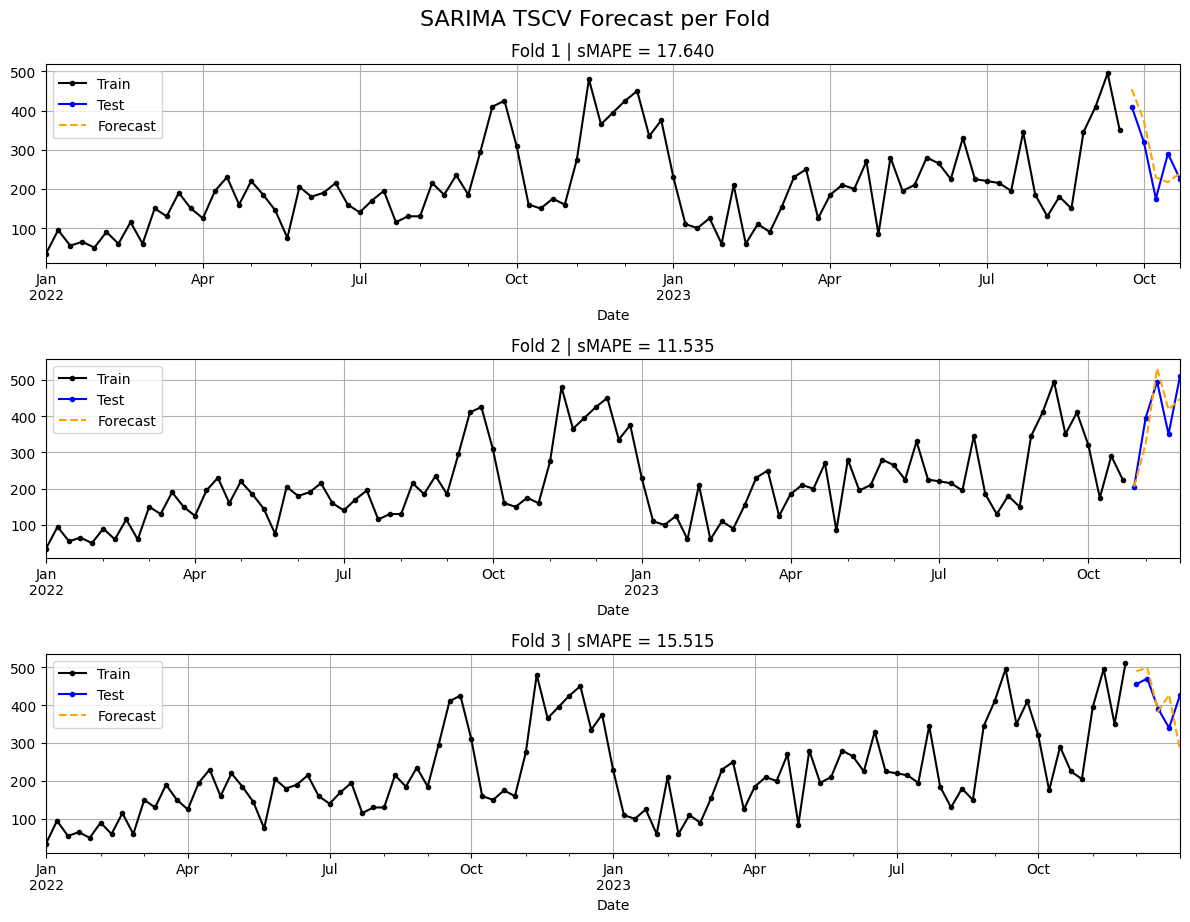

In [ ]:
results = sarima_tscv(
    weekly_all_df['units_sold'], # Use the correct variable name
    order=(2,1,2),
    seasonal_order=(0,1,0,52),
    n_splits=3,
    test_size=5,
    min_train_size= len(weekly_all_df['units_sold'])-10-5)

n_folds = len(results)
fig, axs = plt.subplots(n_folds, 1, figsize=(12, 3 * n_folds), sharex=False)

for i, row in results.iterrows(): # Iterate through DataFrame rows
    ax = axs[i] if n_folds > 1 else axs

    # Access columns by name
    row['y_train'].plot(ax=ax, label='Train', style='.-', color='black')
    row['y_test'].plot(ax=ax, label='Test', style='.-', color='blue')
    if row['y_pred'] is not None:
        row['y_pred'].plot(ax=ax, label='Forecast', style='--', color='orange')

    ax.set_title(f"Fold {row['fold']} | sMAPE = {row['smape']:.3f}") # Access 'fold' and 'r2' by name
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle("SARIMA TSCV Forecast per Fold", fontsize=16, y=1.02)
plt.show()

In [ ]:
# Tambah kolom evaluasi ke DataFrame results
mae_list = []
r2_list = []
log_error_list = []
smapes=[]

for i, row in results.iterrows():
    y_true = row['y_test']
    y_pred = row['y_pred']

    if y_pred is not None:
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        smapes.append(smape(y_true,y_pred))

        # Hindari error log(0) → tambahin epsilon kecil
        epsilon = 1e-9
        y_true_clip = np.maximum(y_true, epsilon)
        y_pred_clip = np.maximum(y_pred, epsilon)
        log_err = np.sqrt(mean_squared_log_error(y_true_clip, y_pred_clip))

    else:
        mae = np.nan
        r2 = np.nan
        log_err = np.nan

    mae_list.append(mae)
    r2_list.append(r2)
    log_error_list.append(log_err)

# Tambahkan ke DataFrame
results['mae'] = mae_list
results['log_rmse'] = log_error_list
results['r2'] = r2_list  # overwrite kalau mau update
results['smape']=smapes

In [ ]:
display(results[['fold', 'mae', 'log_rmse','smape']])
print(f"Mean MAE: {results['mae'].mean():.1f}")
print(f"Mean LogRMSE: {results['log_rmse'].mean():.3f}")
print(f"Mean sMAPE: {results['smape'].mean():.3f}")

,fold,mae,log_rmse,smape
0,1,48.315057,0.198001,17.640273
1,2,47.601553,0.136067,11.534593
2,3,59.634470,0.212484,15.515199


Mean MAE: 51.9
Mean LogRMSE: 0.182
Mean sMAPE: 14.897


## **menggunakan google trend**

tanpa normalisasi


Google Trends Weekly Data:
            car sales  buy a car  car price  auto sales  avg_trend
date                                                              
2022-01-02       29.0       20.0       36.0        81.0      41.50
2022-01-09       29.0       12.0       38.0        65.0      36.00
2022-01-16       24.0       12.0       23.0        74.0      33.25
2022-01-23       21.0       20.0       39.0        85.0      41.25
2022-01-30       30.0       13.0       31.0        75.0      37.25

Info Google Trends Weekly Data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 2022-01-02 to 2023-12-31
Freq: W-SUN
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   car sales   105 non-null    float64
 1   buy a car   105 non-null    float64
 2   car price   105 non-null    float64
 3   auto sales  105 non-null    float64
 4   avg_trend   105 non-null    float64
dtypes: float64(5)
memory usage: 4.9 KB

Merged 

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMAX with Google Trends Feature:
MAE: 106.66 | sMAPE: 32.019


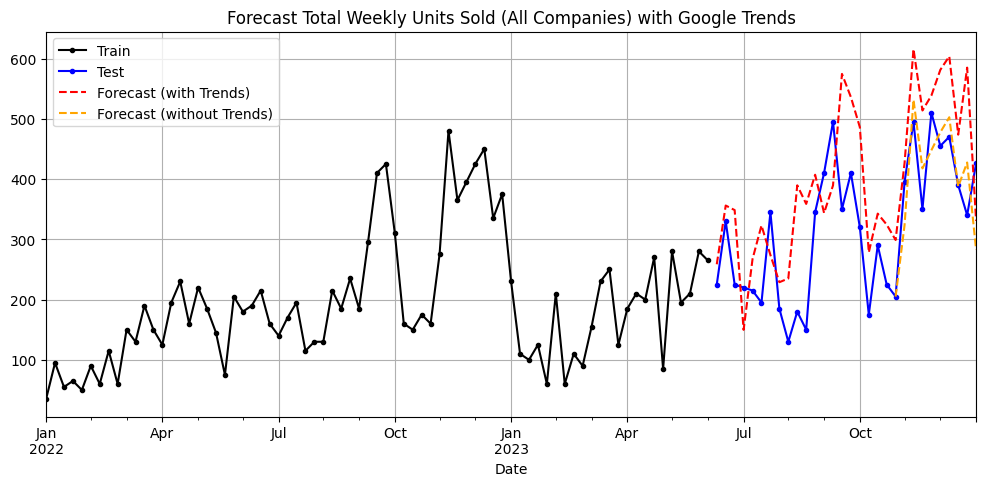

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,fold,mae,log_rmse,smape
0,1,53.446731,0.187040,18.361176
1,2,46.225726,0.133277,11.354506
2,3,66.417287,0.242079,17.345315


Mean MAE (with Trends): 55.4
Mean LogRMSE (with Trends): 0.187
Mean sMAPE (with Trends): 15.687


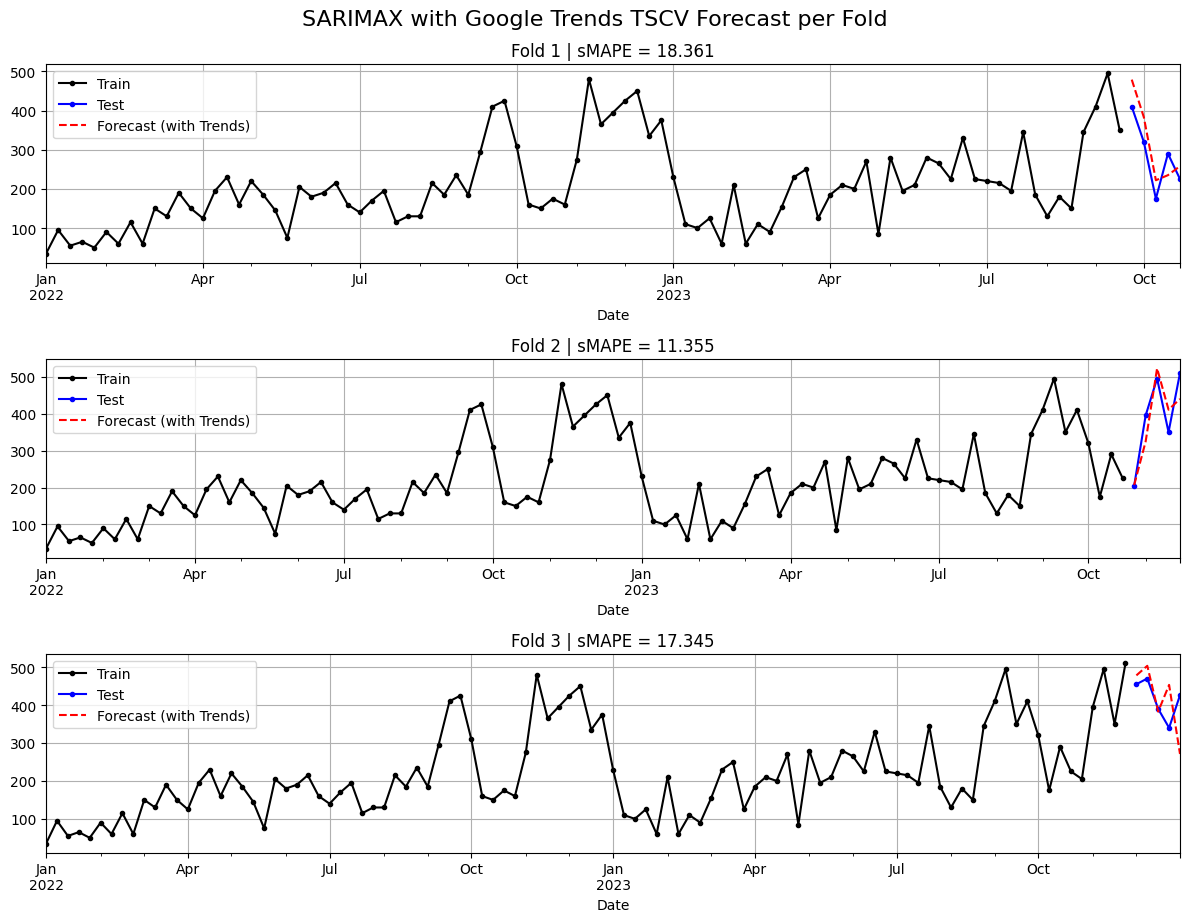

In [ ]:
# Inisialisasi PyTrends
pytrends = TrendReq(hl='en-US', tz=360) # tz is timezone offset in minutes (e.g., 360 for GMT+6) - Adjust as needed

# --- Ambil Data Google Trends ---
# Tentukan keyword yang relevan dengan penjualan mobil
keywords=  ["car sales", "buy a car", "car price", "auto sales"]

# Tentukan rentang waktu
# Start date harus mencakup rentang waktu data penjualan mobil Anda
# End date bisa diperpanjang untuk data yang lebih baru
start_date = df['Date'].min().strftime('%Y-%m-%d')
end_date = df['Date'].max().strftime('%Y-%m-%d') # Atau tanggal yang lebih baru
timeframe = f'{start_date} {end_date}'

try:
    pytrends.build_payload(keywords, cat=71, timeframe=timeframe, geo='US')
    trend_df = pytrends.interest_over_time()

    if 'isPartial' in trend_df.columns:
        trend_df = trend_df.drop(columns='isPartial')

    # Resample ke mingguan
    trend_weekly = trend_df.resample('W').mean()
    trend_weekly['avg_trend'] = trend_weekly.mean(axis=1)

    # Google Trends memberikan data per jam/hari/minggu tergantung rentang waktu.
    # Kita perlu resample atau agregasi agar frekuensinya sama dengan data penjualan mobil (mingguan).
    # Resample ke mingguan ('W') dan hitung rata-rata (mean) minat pencarian
    trend_weekly = trend_df[keywords].resample('W').mean()

    # Buat fitur eksternal baru dengan rata-rata semua keyword atau keyword yang paling relevan
    trend_weekly['avg_trend'] = trend_weekly.mean(axis=1)

    print("\nGoogle Trends Weekly Data:")
    print(trend_weekly.head())
    print("\nInfo Google Trends Weekly Data:")
    trend_weekly.info()

    # --- Gabungkan Data Google Trends dengan Data Penjualan Mobil ---
    trend_weekly['trend_lag_1'] = trend_weekly['avg_trend'].shift(1)
    trend_weekly['trend_lag_2'] = trend_weekly['avg_trend'].shift(2)
    trend_weekly['trend_lag_3'] = trend_weekly['avg_trend'].shift(3)
    trend_weekly['trend_lag_4'] = trend_weekly['avg_trend'].shift(4)


    # Pastikan index Date sama
    merged_df = weekly_all_df.merge(
       trend_weekly[['trend_lag_1', 'trend_lag_2', 'trend_lag_3', 'trend_lag_4']],
       left_index=True, right_index=True, how='left'
      )

    # Isi nilai yang hilang (jika ada, misalnya di awal atau akhir data)
    merged_df[['trend_lag_1', 'trend_lag_2', 'trend_lag_3', 'trend_lag_4']] = (
       merged_df[['trend_lag_1', 'trend_lag_2', 'trend_lag_3', 'trend_lag_4']]
       .bfill()
       .ffill())

    print("\nMerged Data with Google Trends:")
    print(merged_df.head())
    print("\nInfo Merged Data:")
    merged_df.info()

    # --- Persiapan untuk Model SARIMAX dengan Fitur Eksternal ---
    # Pisah kembali train-test set
    y_merged = merged_df['units_sold']
    X_merged = merged_df[['trend_lag_2', 'trend_lag_3']] # Fitur eksternal
    #X_merged = merged_df[['trend_lag_4']] # Fitur eksternal


    n_forecast = 30 # Pastikan konsisten dengan sebelumnya
    train_merged = y_merged[:-n_forecast]
    test_merged = y_merged[-n_forecast:]

    X_train_merged = X_merged.loc[train_merged.index]
    X_test_merged = X_merged.loc[test_merged.index]


    # SARIMA dengan exog (fitur eksternal)
    order = (2, 1, 2)
    seasonal_order = (0, 1, 0, 52)

    model_exog = SARIMAX(train_merged,
                         exog=X_train_merged, # Tambahkan exog
                         order=order,
                         seasonal_order=seasonal_order,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
    fitted_model_exog = model_exog.fit(disp=False)

    # Forecast dengan exog (HARUS menyediakan nilai exog untuk periode forecast)
    # Kita gunakan nilai avg_trend dari X_test_merged
    forecast_exog = fitted_model_exog.forecast(steps=n_forecast, exog=X_test_merged)
    forecast_exog.index = test_merged.index

    # Evaluasi
    mae_exog = mean_absolute_error(test_merged, forecast_exog)
    r2_exog = r2_score(test_merged, forecast_exog)
    smape_exog=smape(test_merged,forecast_exog)

    print(f"\nSARIMAX with Google Trends Feature:")
    print(f"MAE: {mae_exog:.2f} | sMAPE: {smape_exog:.3f}")

    # Plot hasil forecast
    plt.figure(figsize=(12, 5))
    train_merged.plot(label='Train', style='.-', color='black')
    test_merged.plot(label='Test', style='.-', color='blue')
    forecast_exog.plot(label='Forecast (with Trends)', style='--', color='red')
    forecast.plot(label='Forecast (without Trends)', style='--', color='orange') # Bandingkan dengan model lama
    plt.title("Forecast Total Weekly Units Sold (All Companies) with Google Trends")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Fungsi TSCV untuk SARIMAX dengan Exog
    def sarimax_tscv_exog(y, X, order=(2,1,2), seasonal_order=(0,1,0,52),
                          n_splits=5, test_size=10, min_train_size=70):
        results = []

        for i in range(n_splits):
            train_end = min_train_size + i*test_size
            test_start = train_end
            test_end = test_start + test_size

            if test_end > len(y):
                break
            y_train = y[:train_end]
            y_test = y[test_start:test_end]
            X_train = X.loc[y_train.index]
            X_test = X.loc[y_test.index]

            try:
                model = SARIMAX(y_train,
                                exog=X_train, # Tambahkan exog
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                fitted = model.fit(disp=False)
                y_pred = fitted.forecast(steps=test_size, exog=X_test) # Forecast dengan exog test
                y_pred.index = y_test.index

                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                sMAPE=smape(y_test, y_pred)
                epsilon = 1e-9
                y_true_clip = np.maximum(y_test, epsilon)
                y_pred_clip = np.maximum(y_pred, epsilon)
                log_err = np.sqrt(mean_squared_log_error(y_true_clip, y_pred_clip))


                results.append({'fold': i+1, 'mae': mae, 'r2': r2, 'log_rmse': log_err, 'smape': sMAPE,'y_train': y_train, 'y_test': y_test, 'y_pred': y_pred})

            except Exception as e:
                print(f"Fold {i+1} ERROR: {e}")
                results.append({'fold': i+1, 'mae': np.nan, 'r2': np.nan, 'log_rmse': np.nan, 'y_train': y_train, 'y_test': y_test, 'y_pred': None})

        return pd.DataFrame(results)

    # Jalankan TSCV dengan exog
    results_exog = sarimax_tscv_exog(
        y_merged,
        X_merged,
        order=(1,1,2),
        seasonal_order=(0,1,0,52),
        n_splits=3,
        test_size=5,
        min_train_size=len(weekly_all_df['units_sold']) - 10 - 5 # Sesuaikan min_train_size
    )

    display(results_exog[['fold', 'mae', 'log_rmse','smape']])
    #print(f"Mean R² (with Trends): {results_exog['r2'].mean():.3f}")
    print(f"Mean MAE (with Trends): {results_exog['mae'].mean():.1f}")
    print(f"Mean LogRMSE (with Trends): {results_exog['log_rmse'].mean():.3f}")
    print(f"Mean sMAPE (with Trends): {results_exog['smape'].mean():.3f}")



    # Plot TSCV results with exog
    n_folds_exog = len(results_exog)
    fig_exog, axs_exog = plt.subplots(n_folds_exog, 1, figsize=(12, 3 * n_folds_exog), sharex=False)

    for i, row in results_exog.iterrows():
        ax = axs_exog[i] if n_folds_exog > 1 else axs_exog

        row['y_train'].plot(ax=ax, label='Train', style='.-', color='black')
        row['y_test'].plot(ax=ax, label='Test', style='.-', color='blue')
        if row['y_pred'] is not None:
            row['y_pred'].plot(ax=ax, label='Forecast (with Trends)', style='--', color='red')

        ax.set_title(f"Fold {row['fold']} | sMAPE = {row['smape']:.3f}")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.suptitle("SARIMAX with Google Trends TSCV Forecast per Fold", fontsize=16, y=1.02)
    plt.show()


except Exception as e:
    print(f"Error fetching or processing Google Trends data: {e}")
    print("Skipping Google Trends integration for SARIMAX model.")

dengan normalisasi

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMAX with Google Trends Feature (Data Normalized):
MAE: 68.24 | sMAPE: 23.369


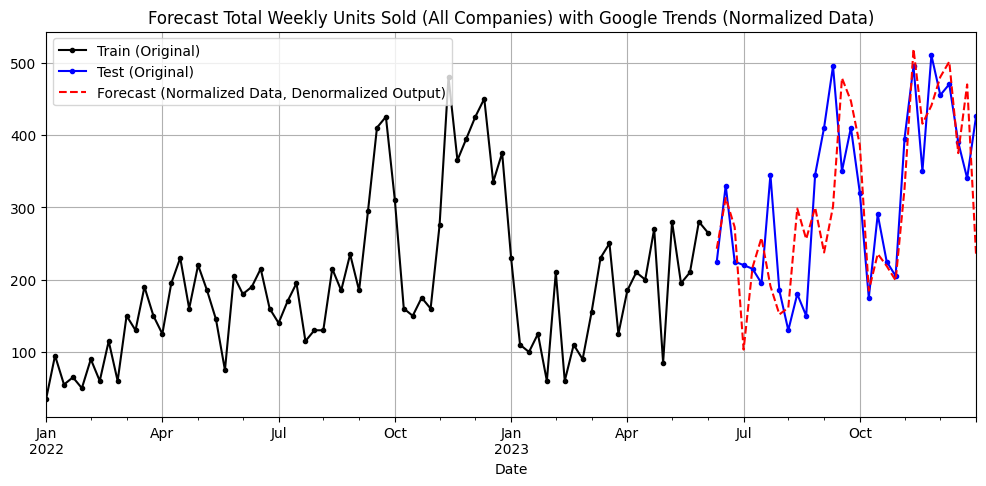

,fold,mae,log_rmse,smape
0,1,52.109934,0.183747,17.956539
1,2,46.215191,0.133315,11.349577
2,3,66.927945,0.244344,17.520197


Mean MAE (with Trends, Normalized Data in Fold): 55.1
Mean LogRMSE (with Trends, Normalized Data in Fold): 0.187
Mean sMAPE (with Trends, Normalized Data in Fold): 15.609


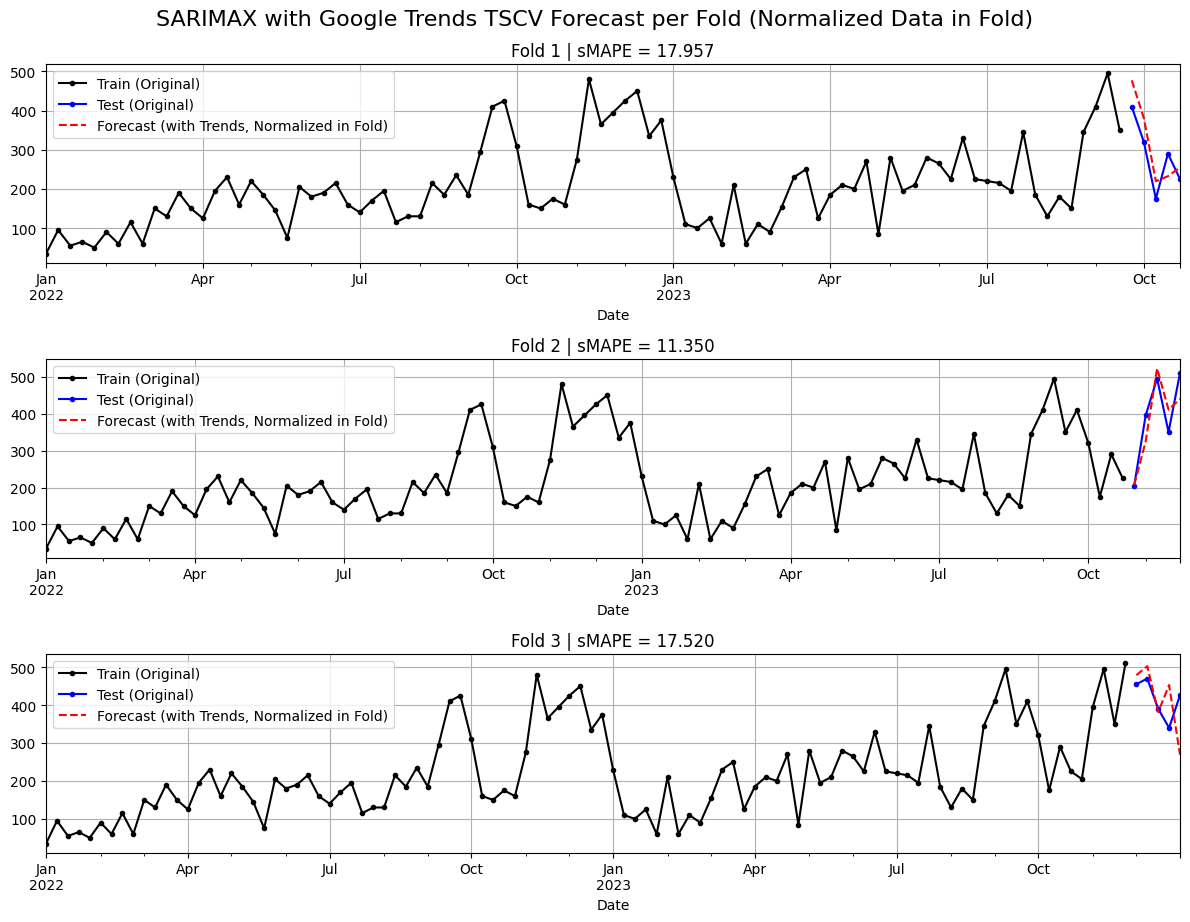

In [ ]:
# Normalisasi data y
scaler_y = MinMaxScaler()
merged_df['units_sold_scaled'] = scaler_y.fit_transform(merged_df[['units_sold']])
y_merged_scaled = merged_df['units_sold_scaled']

# Normalisasi data X
scaler_X = MinMaxScaler()
X_merged_scaled = scaler_X.fit_transform(X_merged)
X_merged_scaled_df = pd.DataFrame(X_merged_scaled, index=X_merged.index, columns=X_merged.columns)


# Pisah kembali train-test set menggunakan data yang sudah dinormalisasi
n_forecast = 30 # Pastikan konsisten dengan sebelumnya
train_merged_scaled = y_merged_scaled[:-n_forecast]
test_merged_scaled = y_merged_scaled[-n_forecast:]

X_train_merged_scaled = X_merged_scaled_df.loc[train_merged_scaled.index]
X_test_merged_scaled = X_merged_scaled_df.loc[test_merged_scaled.index]


# SARIMA dengan exog (fitur eksternal) pada data yang sudah dinormalisasi
order = (2, 1, 2)
seasonal_order = (0, 1, 0, 52)

model_exog_scaled = SARIMAX(train_merged_scaled,
                            exog=X_train_merged_scaled, # Tambahkan exog
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
fitted_model_exog_scaled = model_exog_scaled.fit(disp=False)

# Forecast dengan exog (HARUS menyediakan nilai exog untuk periode forecast)
# Kita gunakan nilai exog yang sudah dinormalisasi dari X_test_merged_scaled
forecast_exog_scaled = fitted_model_exog_scaled.forecast(steps=n_forecast, exog=X_test_merged_scaled)
forecast_exog_scaled.index = test_merged_scaled.index

# Denormalisasi forecast untuk evaluasi dan plotting
forecast_exog_denormalized = scaler_y.inverse_transform(np.array(forecast_exog_scaled).reshape(-1, 1)).flatten()
forecast_exog_denormalized = pd.Series(forecast_exog_denormalized, index=forecast_exog_scaled.index)

# Evaluasi menggunakan data asli (tidak dinormalisasi)
mae_exog_scaled = mean_absolute_error(test_merged, forecast_exog_denormalized)
r2_exog_scaled = r2_score(test_merged, forecast_exog_denormalized)
smape_exog_scaled = smape(test_merged, forecast_exog_denormalized)


print(f"\nSARIMAX with Google Trends Feature (Data Normalized):")
print(f"MAE: {mae_exog_scaled:.2f} | sMAPE: {smape_exog_scaled:.3f}")

# Plot hasil forecast
plt.figure(figsize=(12, 5))
train_merged.plot(label='Train (Original)', style='.-', color='black')
test_merged.plot(label='Test (Original)', style='.-', color='blue')
forecast_exog_denormalized.plot(label='Forecast (Normalized Data, Denormalized Output)', style='--', color='red')
# forecast.plot(label='Forecast (without Trends, Original Data)', style='--', color='orange') # Bandingkan dengan model lama
plt.title("Forecast Total Weekly Units Sold (All Companies) with Google Trends (Normalized Data)")
plt.legend()
plt.grid(True)
plt.show()


# Fungsi TSCV untuk SARIMAX dengan Exog dan Normalisasi/Denormalisasi
def sarimax_tscv_exog_scaled(y_original, X_original,
                             order=(2,1,2), seasonal_order=(0,1,0,52),
                             n_splits=5, test_size=10, min_train_size=70):
    results = []

    # Inisialisasi scalers di luar loop fold jika perlu
    scaler_y_fold = MinMaxScaler()
    scaler_X_fold = MinMaxScaler()

    for i in range(n_splits):
        train_end = min_train_size + i*test_size
        test_start = train_end
        test_end = test_start + test_size

        if test_end > len(y_original):
            break

        y_train_original = y_original[:train_end]
        y_test_original = y_original[test_start:test_end]
        X_train_original = X_original.loc[y_train_original.index]
        X_test_original = X_original.loc[y_test_original.index]

        # Fit dan transform data untuk fold ini
        y_train_scaled = scaler_y_fold.fit_transform(y_train_original.values.reshape(-1, 1)).flatten()
        X_train_scaled = scaler_X_fold.fit_transform(X_train_original)
        X_test_scaled = scaler_X_fold.transform(X_test_original)


        try:
            model = SARIMAX(y_train_scaled,
                            exog=X_train_scaled, # Tambahkan exog yang sudah discale
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            fitted = model.fit(disp=False)

            # Forecast pada data scaled
            y_pred_scaled = fitted.forecast(steps=test_size, exog=X_test_scaled) # Forecast dengan exog test scaled

            # Denormalisasi forecast
            y_pred_denormalized = scaler_y_fold.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).flatten()
            y_pred_denormalized = pd.Series(y_pred_denormalized, index=y_test_original.index) # Pastikan index sama dengan y_test_original

            # Evaluasi menggunakan data original (tidak dinormalisasi)
            mae = mean_absolute_error(y_test_original, y_pred_denormalized)
            r2 = r2_score(y_test_original, y_pred_denormalized)
            sMAPE = smape(y_test_original, y_pred_denormalized)
            epsilon = 1e-9
            y_true_clip = np.maximum(y_test_original, epsilon)
            y_pred_clip = np.maximum(y_pred_denormalized, epsilon)
            log_err = np.sqrt(mean_squared_log_error(y_true_clip, y_pred_clip))


            results.append({'fold': i+1, 'mae': mae, 'r2': r2, 'log_rmse': log_err, 'smape': sMAPE,
                            'y_train': y_train_original, 'y_test': y_test_original, 'y_pred': y_pred_denormalized})

        except Exception as e:
            print(f"Fold {i+1} ERROR: {e}")
            results.append({'fold': i+1, 'mae': np.nan, 'r2': np.nan, 'log_rmse': np.nan, 'smape': np.nan,
                            'y_train': y_train_original, 'y_test': y_test_original, 'y_pred': None})

    return pd.DataFrame(results)

# Jalankan TSCV dengan exog pada data yang dinormalisasi di dalam loop
results_exog_scaled_tscv = sarimax_tscv_exog_scaled(
    y_merged,           # Gunakan data y original
    X_merged,           # Gunakan data X original
    order=(1,1,2),
    seasonal_order=(0,1,0,52),
    n_splits=3,
    test_size=5,
    min_train_size=len(weekly_all_df['units_sold']) - 10 - 5 # Sesuaikan min_train_size
)

display(results_exog_scaled_tscv[['fold', 'mae', 'log_rmse','smape']])
print(f"Mean MAE (with Trends, Normalized Data in Fold): {results_exog_scaled_tscv['mae'].mean():.1f}")
print(f"Mean LogRMSE (with Trends, Normalized Data in Fold): {results_exog_scaled_tscv['log_rmse'].mean():.3f}")
print(f"Mean sMAPE (with Trends, Normalized Data in Fold): {results_exog_scaled_tscv['smape'].mean():.3f}")


# Plot TSCV results with exog and normalization
n_folds_exog_scaled_tscv = len(results_exog_scaled_tscv)
fig_exog_scaled_tscv, axs_exog_scaled_tscv = plt.subplots(n_folds_exog_scaled_tscv, 1, figsize=(12, 3 * n_folds_exog_scaled_tscv), sharex=False)

for i, row in results_exog_scaled_tscv.iterrows():
    ax = axs_exog_scaled_tscv[i] if n_folds_exog_scaled_tscv > 1 else axs_exog_scaled_tscv

    row['y_train'].plot(ax=ax, label='Train (Original)', style='.-', color='black')
    row['y_test'].plot(ax=ax, label='Test (Original)', style='.-', color='blue')
    if row['y_pred'] is not None:
        row['y_pred'].plot(ax=ax, label='Forecast (with Trends, Normalized in Fold)', style='--', color='red')

    ax.set_title(f"Fold {row['fold']} | sMAPE = {row['smape']:.3f}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle("SARIMAX with Google Trends TSCV Forecast per Fold (Normalized Data in Fold)", fontsize=16, y=1.02)
plt.show()



## **Hybrid SARIMA+LinearRegression**

In [ ]:
def tscv_sarimax_poly(y, order=(2,1,2), seasonal_order=(0,1,0,52),
                      poly_degree=10, n_splits=5, test_size=10, min_train_size=70):
    results = []

    for i in range(n_splits):
        train_end = min_train_size + i*test_size
        test_start = train_end
        test_end = test_start + test_size
        if test_end > len(y):
            break

        y_train = y[:train_end]
        y_test = y[test_start:test_end]

        try:
            # === Fit SARIMAX
            sarima = SARIMAX(y_train,
                             order=order,
                             seasonal_order=seasonal_order,
                             enforce_stationarity=False,
                             enforce_invertibility=False).fit(disp=False)

            sarima_pred = sarima.forecast(steps=test_size)
            sarima_pred.index = y_test.index

            # === Residual dari training data
            sarima_fitted = sarima.fittedvalues.reindex(y_train.index) # Reindex to match y_train index
            resid = y_train - sarima_fitted
            # resid = resid.dropna() # Remove dropna()

            # === Fit Polynomial Regression ke resid
            t_train = np.arange(len(resid)).reshape(-1, 1) # Use length of resid
            poly_model = Pipeline([
                ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
                ('linreg', LinearRegression())
            ]).fit(t_train, resid.values)

            # === Forecast resid ke depan (test_size langkah)
            t_future = np.arange(len(resid), len(resid)+test_size).reshape(-1, 1) # Use length of resid
            poly_forecast = poly_model.predict(t_future)
            poly_forecast = pd.Series(poly_forecast, index=y_test.index)

            # === Hybrid forecast
            hybrid_forecast = sarima_pred + poly_forecast

            # === Evaluasi
            mae = mean_absolute_error(y_test, hybrid_forecast)
            r2 = r2_score(y_test, hybrid_forecast)
            sMAPE_val = smape(y_test, hybrid_forecast)


            results.append({
                'fold': i+1,
                'mae': mae,
                'r2': r2,
                'smape':sMAPE_val,
                'y_train': y_train,
                'y_test': y_test,
                'sarima_pred': sarima_pred,
                'hybrid_pred': hybrid_forecast
            })

        except Exception as e:
            print(f"Fold {i+1} ERROR: {e}")
            results.append({
                'fold': i+1,
                'mae': None,
                'r2': None,
                'smape':None,
                'y_train': y_train,
                'y_test': y_test,
                'sarima_pred': None,
                'hybrid_pred': None
            })

    return pd.DataFrame(results)

In [ ]:
y = weekly_all_df['units_sold'].asfreq('W')

results_hybrid = tscv_sarimax_poly(
    y,
    order=(2,1,2),
    seasonal_order=(0,1,0,52),
    poly_degree=3,
    n_splits=3,
    test_size=5,
    min_train_size=len(y) - 10 - 5
)

display(results_hybrid[['fold', 'mae','smape']])

,fold,mae,smape
0,1,82.286024,26.752154
1,2,54.176616,13.807531
2,3,73.501624,17.730625


In [ ]:
print(f"Mean sMAPE hybrid: {results_hybrid['smape'].mean():.3f}")

Mean sMAPE hybrid: 19.430


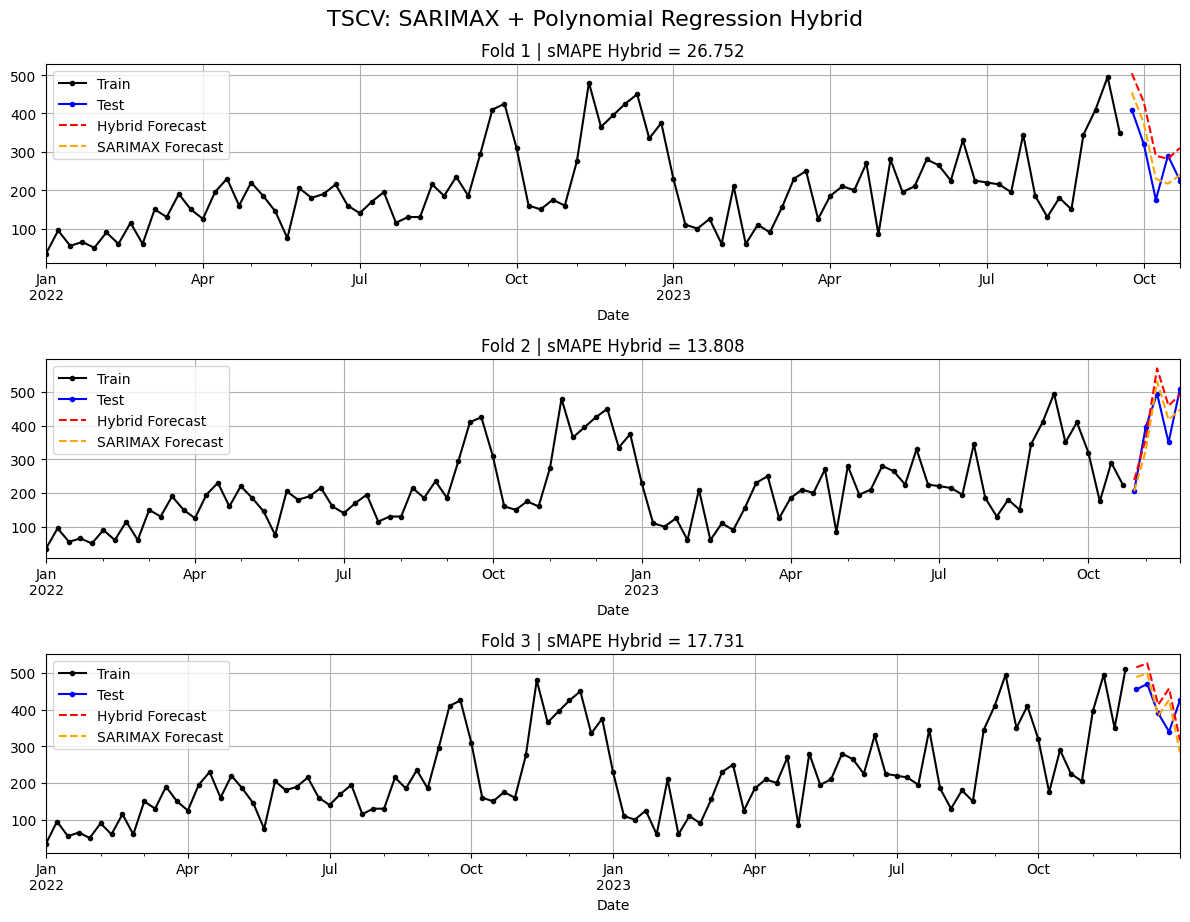

In [ ]:
n_folds = len(results_hybrid)
fig, axs = plt.subplots(n_folds, 1, figsize=(12, 3 * n_folds), sharex=False)

for i, row in results_hybrid.iterrows():
    ax = axs[i] if n_folds > 1 else axs

    row['y_train'].plot(ax=ax, label='Train', color='black', style='.-')
    row['y_test'].plot(ax=ax, label='Test', color='blue', style='.-')
    if row['hybrid_pred'] is not None:
        row['hybrid_pred'].plot(ax=ax, label='Hybrid Forecast', color='red', style='--')
    if row['sarima_pred'] is not None:
        row['sarima_pred'].plot(ax=ax, label='SARIMAX Forecast', color='orange', style='--')

    ax.set_title(f"Fold {row['fold']} | sMAPE Hybrid = {row['smape']:.3f}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle("TSCV: SARIMAX + Polynomial Regression Hybrid", fontsize=16, y=1.02)
plt.show()

## **FINAL MODEL: SARIMAX + trends**

kesimpulan: model terbaik adalah SARIMAX dengan variabel eksternal dari google trend dengan sMAPE=14.911%

In [ ]:
display(results_exog[['fold', 'mae', 'log_rmse']])
print(f"Mean sMAPE: {results_exog['smape'].mean():.3f}")
print(f"Mean MAE: {results_exog['mae'].mean():.1f}")
print(f"Mean LogRMSE: {results_exog['log_rmse'].mean():.3f}")


,fold,mae,log_rmse
0,1,53.446731,0.187040
1,2,46.225726,0.133277
2,3,66.417287,0.242079


Mean sMAPE: 15.687
Mean MAE: 55.4
Mean LogRMSE: 0.187


**Prediksi beberapa minggu ke depan**

perlu membuat model untuk memprediksi trend juga

In [ ]:
trend_series = trend_weekly['avg_trend']
n_forecast = 10
train_trend = trend_series[:-n_forecast]
test_trend = trend_series[-n_forecast:]

model = SARIMAX(train_trend, order=(1,1,1), seasonal_order=(0,1,0,52),
                enforce_stationarity=False, enforce_invertibility=False)
fitted = model.fit(disp=False)

y_pred = fitted.forecast(steps=n_forecast)
y_pred.index = test_trend.index

mae = mean_absolute_error(test_trend, y_pred)
sMAPE = smape(test_trend, y_pred)

print(f"MAE Trend : {mae:.2f}")
print(f"sMAPE     : {sMAPE:.2f}%")


MAE Trend : 3.07
sMAPE     : 9.35%


grid search

In [ ]:
# Dataset
trend_series = trend_weekly['avg_trend']
n_forecast = 10
train = trend_series[:-n_forecast]
test = trend_series[-n_forecast:]

# Parameter ranges
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 52

results = []
best_smape = float('inf')
best_model = None

for order in itertools.product(p, [1], q):
    for seasonal in itertools.product(P, [1], Q):
        seasonal_order = seasonal + (s,)
        try:
            model = SARIMAX(train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            fitted = model.fit(disp=False)
            forecast = fitted.forecast(steps=n_forecast)
            forecast.index = test.index

            score = smape(test, forecast)
            results.append((order, seasonal_order, score))

            if score < best_smape:
                best_smape = score
                best_model = (order, seasonal_order, forecast)

            print(f"SARIMA{order}x{seasonal_order} → sMAPE: {score:.2f}%")

        except Exception as e:
            print(f"Failed SARIMA{order}x{seasonal_order} → {e}")

# Hasil terbaik
best_order, best_seasonal_order, best_forecast = best_model
print("\n🔍 Best SARIMA Configuration:")
print(f"Order: {best_order}")
print(f"Seasonal Order: {best_seasonal_order}")
print(f"Best sMAPE: {best_smape:.2f}%")

SARIMA(0, 1, 0)x(0, 1, 0, 52) → sMAPE: 9.27%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 0)x(0, 1, 1, 52) → sMAPE: 9.27%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 0)x(1, 1, 0, 52) → sMAPE: 9.27%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 0)x(1, 1, 1, 52) → sMAPE: 9.27%
SARIMA(0, 1, 1)x(0, 1, 0, 52) → sMAPE: 9.32%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 1)x(0, 1, 1, 52) → sMAPE: 9.46%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 1)x(1, 1, 0, 52) → sMAPE: 9.46%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 1)x(1, 1, 1, 52) → sMAPE: 9.46%
SARIMA(0, 1, 2)x(0, 1, 0, 52) → sMAPE: 9.36%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 2)x(0, 1, 1, 52) → sMAPE: 9.42%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 2)x(1, 1, 0, 52) → sMAPE: 9.42%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 2)x(1, 1, 1, 52) → sMAPE: 9.42%
SARIMA(1, 1, 0)x(0, 1, 0, 52) → sMAPE: 9.13%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 0)x(0, 1, 1, 52) → sMAPE: 9.13%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 0)x(1, 1, 0, 52) → sMAPE: 9.13%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 0)x(1, 1, 1, 52) → sMAPE: 9.13%
SARIMA(1, 1, 1)x(0, 1, 0, 52) → sMAPE: 9.35%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 1)x(0, 1, 1, 52) → sMAPE: 9.46%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 1)x(1, 1, 0, 52) → sMAPE: 9.46%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 1)x(1, 1, 1, 52) → sMAPE: 9.46%
SARIMA(1, 1, 2)x(0, 1, 0, 52) → sMAPE: 9.37%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 2)x(0, 1, 1, 52) → sMAPE: 9.44%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 2)x(1, 1, 0, 52) → sMAPE: 9.44%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 2)x(1, 1, 1, 52) → sMAPE: 9.44%
SARIMA(2, 1, 0)x(0, 1, 0, 52) → sMAPE: 9.39%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 0)x(0, 1, 1, 52) → sMAPE: 9.39%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 0)x(1, 1, 0, 52) → sMAPE: 9.39%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 0)x(1, 1, 1, 52) → sMAPE: 9.39%
SARIMA(2, 1, 1)x(0, 1, 0, 52) → sMAPE: 9.35%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 1)x(0, 1, 1, 52) → sMAPE: 9.44%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 1)x(1, 1, 0, 52) → sMAPE: 9.44%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 1)x(1, 1, 1, 52) → sMAPE: 9.44%
SARIMA(2, 1, 2)x(0, 1, 0, 52) → sMAPE: 9.36%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 2)x(0, 1, 1, 52) → sMAPE: 9.37%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 2)x(1, 1, 0, 52) → sMAPE: 9.37%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(2, 1, 2)x(1, 1, 1, 52) → sMAPE: 9.37%

🔍 Best SARIMA Configuration:
Order: (1, 1, 0)
Seasonal Order: (0, 1, 1, 52)
Best sMAPE: 9.13%


In [ ]:
# Fit model SARIMA sederhana untuk avg_trend
model_trend = SARIMAX(trend_weekly['avg_trend'], order=(0,1,0), seasonal_order=(0,1,1,52),
                      enforce_stationarity=False, enforce_invertibility=False)
fit_trend = model_trend.fit(disp=False)

# Forecast 10 minggu ke depan
n_forecast = 10
trend_forecast = fit_trend.forecast(steps=n_forecast)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
exog_forecast = pd.DataFrame({
    'trend_lag_2': trend_forecast.shift(2),
    'trend_lag_3': trend_forecast.shift(3),
})

# Isi NaN akibat shift dengan metode backfill supaya ada nilai
exog_forecast = exog_forecast.fillna(method='bfill')

# Index exog_forecast sesuaikan dengan tanggal forecast (misal mulai dari minggu setelah data terakhir)
last_date = trend_weekly.index[-1]
exog_forecast.index = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=n_forecast, freq='W')

/tmp/ipython-input-30-185256830.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_forecast = exog_forecast.fillna(method='bfill')


In [ ]:
# gabungkan semua lag tren ke merged_df
merged_df = weekly_all_df.merge(
    trend_weekly[['trend_lag_2', 'trend_lag_3']],
    left_index=True, right_index=True, how='left'
)

# isi NaN pada fitur tren
merged_df.fillna(method='bfill', inplace=True)
merged_df.fillna(method='ffill', inplace=True)

y = merged_df['units_sold']
X = merged_df[['trend_lag_2', 'trend_lag_3']]

FinalSARIMAXModel = SARIMAX(y,
                      exog=X,
                      order=(2,1,2),
                      seasonal_order=(0,1,0,52),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
fitted_units = FinalSARIMAXModel.fit(disp=False)

/tmp/ipython-input-31-4175488882.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-31-4175488882.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast_units = fitted_units.forecast(steps=n_forecast, exog=exog_forecast)

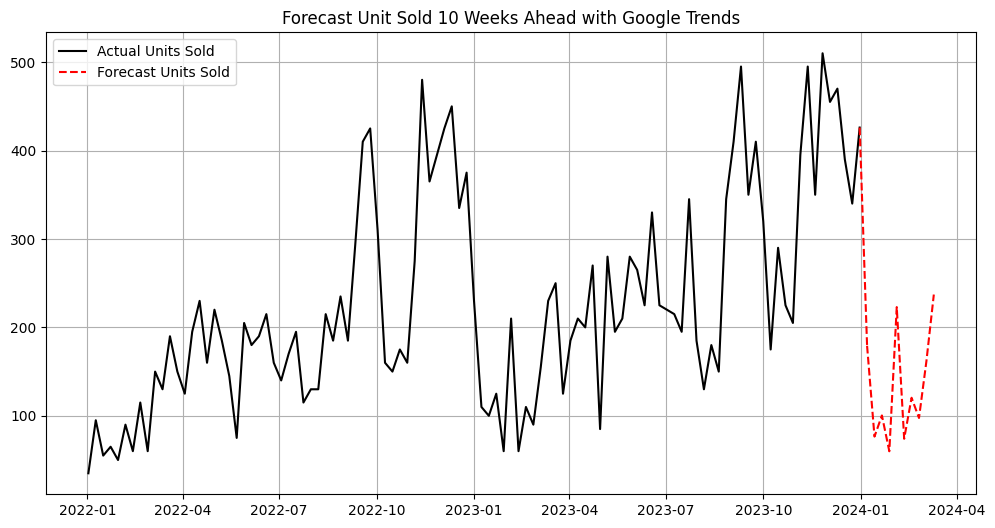

In [ ]:
plt.figure(figsize=(12,6))

# Plot actual data
plt.plot(y.index, y.values, label='Actual Units Sold', color='black')

# Plot titik terakhir actual dan titik pertama forecast, sambungkan garis lurus
plt.plot([y.index[-1], forecast_units.index[0]],
         [y.values[-1], forecast_units.iloc[0]],
         color='red', linestyle='--')

# Plot forecast data
plt.plot(forecast_units.index, forecast_units.values, label='Forecast Units Sold', color='red', linestyle='--')

plt.title('Forecast Unit Sold 10 Weeks Ahead with Google Trends')
plt.legend()
plt.grid(True)
plt.show()


# Upload

In [ ]:
# --- Load Data & Merge ---
merged_df = weekly_all_df.merge(
    trend_weekly[['trend_lag_2', 'trend_lag_3']],
    left_index=True, right_index=True, how='left'
)
merged_df.fillna(method='bfill', inplace=True)
merged_df.fillna(method='ffill', inplace=True)

# --- Scaling ---
scaler_y = MinMaxScaler()
scaler_X = MinMaxScaler()

y_scaled_array = scaler_y.fit_transform(merged_df[['units_sold']])
X_scaled_array = scaler_X.fit_transform(merged_df[['trend_lag_2', 'trend_lag_3']])

# Kembalikan jadi pd.Series dan DataFrame dengan index yang sama
y_scaled = pd.Series(y_scaled_array.flatten(), index=merged_df.index)
X_scaled = pd.DataFrame(X_scaled_array, columns=['trend_lag_2', 'trend_lag_3'], index=merged_df.index)

# --- Simpan Scaler ---
joblib.dump(scaler_y, "scaler_y.pkl")
joblib.dump(scaler_X, "scaler_X.pkl")

# --- Training SARIMAX ---
model = SARIMAX(
    y_scaled,
    exog=X_scaled,
    order=(2,1,2),
    seasonal_order=(0,1,0,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

fitted_model = model.fit(disp=False)

# --- Simpan Model ---
joblib.dump(fitted_model, "sarimax_scaled_model.pkl")

# --- Model & Scaler untuk Trend ---

# Definisikan trend_series dengan jelas
trend_series = trend_weekly['avg_trend']

scaler_trend = MinMaxScaler()
trend_scaled_array = scaler_trend.fit_transform(trend_series.values.reshape(-1,1))
trend_scaled = pd.Series(trend_scaled_array.flatten(), index=trend_series.index)

joblib.dump(scaler_trend, 'scaler_trend.pkl')

model_trend = SARIMAX(
    trend_scaled,
    order=(0,1,0),
    seasonal_order=(0,1,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

fitted_trend = model_trend.fit(disp=False)

joblib.dump(fitted_trend, 'sarima_trend_model.pkl')


/tmp/ipython-input-39-1341698914.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-39-1341698914.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


['sarima_trend_model.pkl']